<a href="https://colab.research.google.com/github/MayerT1/Forest_Structure_Function_Module/blob/main/Meta_model_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Meta Model approach

https://dataaspirant.com/stacking-technique/

https://www.youtube.com/watch?v=0BGLfYY26zQ

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html

https://github.com/dataprofessor/python/blob/main/Stacking_Classifier.ipynb

In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from subprocess import check_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/sample_partition
!ls

/content/drive/MyDrive/sample_partition
op_rf.csv  rf_individualtree.png  temp_file.pdf  training.csv
out.csv    temp_file		  testing.csv	 validation.csv


In [5]:
train=pd.read_csv("training.csv")
print("Train dataset has {} samples and {} attributes".format(*train.shape))


train_copy = train.copy()
train_copy

Train dataset has 4000 samples and 39 attributes


,system:index,MNDWI_HLS,MNDWI_LS,NDBI_HLS,NDBI_LS,NDMI_HLS,NDMI_LS,NDWI_HLS,NDWI_LS,S2_EVI,...,ndratio_D,random,ratio_A,ratio_D,rh100,rh100_1,sixth,slope,wetness,.geo
0,0,-0.476459,-0.483751,-0.130499,-0.082585,0.130499,0.082585,-0.571429,-0.544580,0.330213,...,-0.244325,0.375833,0.616171,0.607297,12.17,12.17,-0.025443,8.962334,-0.036204,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,1,-0.513142,-0.506553,-0.063932,-0.094034,0.063932,0.094034,-0.558744,-0.573255,0.334227,...,-0.367666,0.489221,0.556244,0.462346,9.02,9.02,-0.026757,30.805159,-0.067350,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,2,-0.347756,-0.431080,-0.198843,-0.079194,0.198843,0.079194,-0.511246,-0.494425,0.279654,...,-0.281740,0.390793,0.615712,0.560379,30.37,30.37,-0.025926,24.337640,-0.036167,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,3,-0.464122,-0.449512,-0.094130,-0.146172,0.094130,0.146172,-0.534884,-0.558573,0.305338,...,-0.278446,0.339658,0.403031,0.564399,6.03,6.03,-0.026175,15.251116,-0.027220,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,4,-0.514694,-0.500345,-0.176820,-0.127935,0.176820,0.127935,-0.633830,-0.590409,0.408838,...,-0.310714,0.632521,0.601882,0.525885,29.63,29.63,-0.024789,40.856106,-0.025176,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,-0.447009,-0.485910,-0.224438,-0.234370,0.224438,0.234370,-0.610226,-0.647239,0.351286,...,-0.237188,0.757970,0.661079,0.616570,24.16,24.16,-0.021303,27.470978,0.010576,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3996,3996,-0.492698,-0.509375,-0.001274,-0.037905,0.001274,0.037905,-0.493663,-0.536472,0.274115,...,-0.348678,0.986754,0.661795,0.482934,18.19,18.19,-0.022175,44.096733,-0.069757,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3997,3997,-0.417832,-0.417754,-0.080108,-0.127399,0.080108,0.127399,-0.481813,-0.517541,0.272994,...,-0.406340,0.639939,0.690515,0.422131,12.86,12.86,-0.027658,24.573717,-0.013164,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3998,3998,-0.481723,-0.472172,-0.125578,-0.095149,0.125578,0.095149,-0.572659,-0.542671,0.316540,...,-0.380542,0.449982,0.591584,0.448706,16.18,16.18,-0.026552,39.699720,-0.023182,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


Test dataset has 4000 samples and 39 attributes
rh100 height distribution of Testing Data set


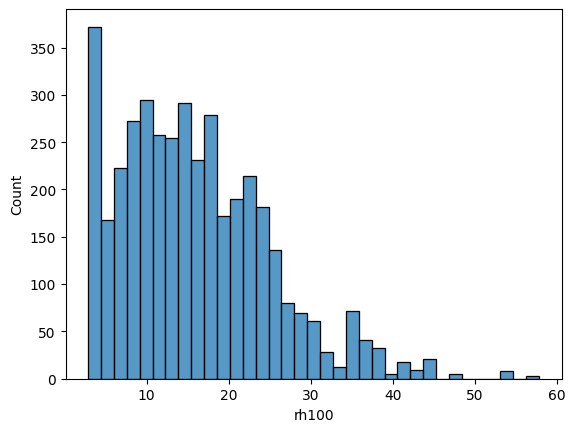

In [7]:
test=pd.read_csv("testing.csv")
print("Test dataset has {} samples and {} attributes".format(*test.shape))

print("rh100 height distribution of Testing Data set")
sns.histplot(test,x="rh100")

test["rh100"].describe()

test_copy = test.copy()


validation dataset has 4000 samples and 39 attributes
rh100 height distribution of validation Data set


,system:index,MNDWI_HLS,MNDWI_LS,NDBI_HLS,NDBI_LS,NDMI_HLS,NDMI_LS,NDWI_HLS,NDWI_LS,S2_EVI,...,ndratio_D,random,ratio_A,ratio_D,rh100,rh100_1,sixth,slope,wetness,.geo
0,0,-0.494053,-0.504159,-0.148396,-0.110995,0.148396,0.110995,-0.598564,-0.582714,0.434859,...,-0.343695,0.919010,0.490248,0.488433,11.57,11.57,-0.022234,33.972160,-0.044953,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,1,-0.447435,-0.465173,-0.218438,-0.193754,0.218438,0.193754,-0.606587,-0.604414,0.304677,...,-0.412988,0.796395,0.662576,0.415441,24.82,24.82,-0.024862,37.160007,-0.020732,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,2,-0.421499,-0.421931,-0.034435,-0.046049,0.034435,0.046049,-0.449411,-0.458946,0.244350,...,-0.314065,0.320410,0.415834,0.521994,21.51,21.51,-0.028558,35.237755,-0.054639,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,3,-0.559169,-0.541922,0.011822,0.004801,-0.011822,-0.004801,-0.550989,-0.538672,0.312022,...,-0.327964,0.986099,0.659977,0.506065,8.57,8.57,-0.025516,18.442694,-0.079794,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,4,-0.492933,-0.505962,-0.170624,-0.193645,0.170624,0.193645,-0.612078,-0.637087,0.370927,...,-0.296168,0.312414,0.544326,0.543010,13.55,13.55,-0.022800,37.830444,-0.033048,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,-0.386014,-0.439079,-0.279535,-0.301627,0.279535,0.301627,-0.600728,-0.656509,0.383362,...,-0.194067,0.851925,0.636311,0.674948,26.56,26.56,-0.020387,20.973866,0.020052,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3996,3996,-0.526805,-0.452232,-0.170163,-0.193986,0.170163,0.193986,-0.639630,-0.592931,0.388036,...,-0.296479,0.490643,0.716262,0.542639,5.76,5.76,-0.023862,40.621720,0.013260,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3997,3997,-0.494771,-0.529063,-0.217245,-0.137723,0.217245,0.137723,-0.642911,-0.621255,0.403282,...,-0.218779,0.933606,0.539499,0.640986,19.40,19.40,-0.021803,28.870852,-0.007699,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3998,3998,-0.540741,-0.491472,-0.339944,-0.305695,0.339944,0.305695,-0.743934,-0.692829,0.677823,...,-0.268119,0.875979,0.625153,0.577139,25.32,25.32,-0.020601,34.309658,0.026200,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


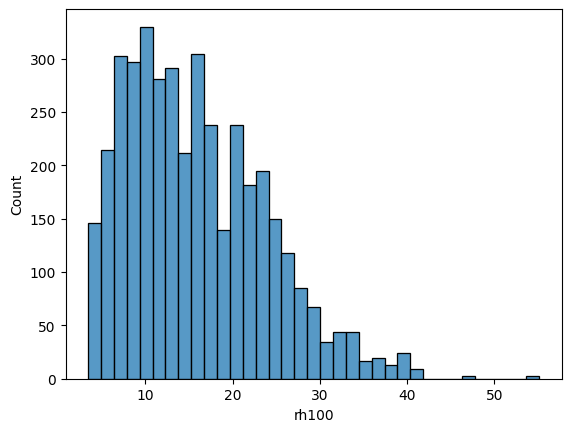

In [9]:
validation=pd.read_csv("validation.csv")
print("validation dataset has {} samples and {} attributes".format(*validation.shape))

print("rh100 height distribution of validation Data set")
sns.histplot(validation,x="rh100")

validation["rh100"].describe()

validation_copy = validation.copy()
validation_copy

# Data handeling

train

In [8]:
y_train=pd.DataFrame(train_copy['rh100'])
y_train

,rh100
0,12.17
1,9.02
2,30.37
3,6.03
4,29.63
...,...
3995,24.16
3996,18.19
3997,12.86
3998,16.18


In [10]:
train_copy.drop(['system:index', 'class', 'rh100', 'rh100_1', 'random', '.geo'], axis=1, inplace=True)
x_train = train_copy
x_train

,MNDWI_HLS,MNDWI_LS,NDBI_HLS,NDBI_LS,NDMI_HLS,NDMI_LS,NDWI_HLS,NDWI_LS,S2_EVI,S2_MNDWI,...,fifth,fourth,greenness,ndratio_A,ndratio_D,ratio_A,ratio_D,sixth,slope,wetness
0,-0.476459,-0.483751,-0.130499,-0.082585,0.130499,0.082585,-0.571429,-0.544580,0.330213,-0.284712,...,0.028322,-0.048771,0.072463,-0.237492,-0.244325,0.616171,0.607297,-0.025443,8.962334,-0.036204
1,-0.513142,-0.506553,-0.063932,-0.094034,0.063932,0.094034,-0.558744,-0.573255,0.334227,-0.278585,...,0.050240,-0.052690,0.084146,-0.285145,-0.367666,0.556244,0.462346,-0.026757,30.805159,-0.067350
2,-0.347756,-0.431080,-0.198843,-0.079194,0.198843,0.079194,-0.511246,-0.494425,0.279654,-0.238936,...,0.022685,-0.051023,0.036122,-0.237844,-0.281740,0.615712,0.560379,-0.025926,24.337640,-0.036167
3,-0.464122,-0.449512,-0.094130,-0.146172,0.094130,0.146172,-0.534884,-0.558573,0.305338,-0.245688,...,0.031012,-0.052227,0.055076,-0.425485,-0.278446,0.403031,0.564399,-0.026175,15.251116,-0.027220
4,-0.514694,-0.500345,-0.176820,-0.127935,0.176820,0.127935,-0.633830,-0.590409,0.408838,-0.285918,...,0.017475,-0.052967,0.063344,-0.248531,-0.310714,0.601882,0.525885,-0.024789,40.856106,-0.025176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.447009,-0.485910,-0.224438,-0.234370,0.224438,0.234370,-0.610226,-0.647239,0.351286,-0.247138,...,0.004797,-0.054043,0.028199,-0.204037,-0.237188,0.661079,0.616570,-0.021303,27.470978,0.010576
3996,-0.492698,-0.509375,-0.001274,-0.037905,0.001274,0.037905,-0.493663,-0.536472,0.274115,-0.266557,...,0.045228,-0.050750,0.057290,-0.203518,-0.348678,0.661795,0.482934,-0.022175,44.096733,-0.069757
3997,-0.417832,-0.417754,-0.080108,-0.127399,0.080108,0.127399,-0.481813,-0.517541,0.272994,-0.268069,...,0.017810,-0.055982,0.036919,-0.183071,-0.406340,0.690515,0.422131,-0.027658,24.573717,-0.013164
3998,-0.481723,-0.472172,-0.125578,-0.095149,0.125578,0.095149,-0.572659,-0.542671,0.316540,-0.265336,...,0.020602,-0.054387,0.059407,-0.256609,-0.380542,0.591584,0.448706,-0.026552,39.699720,-0.023182


test

In [11]:
y_test=pd.DataFrame(test_copy['rh100'])
y_test

,rh100
0,12.280000
1,3.370000
2,13.070000
3,7.567164
4,17.070000
...,...
3995,11.010000
3996,17.630000
3997,17.070000
3998,27.987840


In [12]:
test_copy.drop(['system:index', 'class', 'rh100', 'rh100_1', 'random', '.geo'], axis=1, inplace=True)
x_test = test_copy
x_test

,MNDWI_HLS,MNDWI_LS,NDBI_HLS,NDBI_LS,NDMI_HLS,NDMI_LS,NDWI_HLS,NDWI_LS,S2_EVI,S2_MNDWI,...,fifth,fourth,greenness,ndratio_A,ndratio_D,ratio_A,ratio_D,sixth,slope,wetness
0,-0.404359,-0.403206,-0.106046,-0.094519,0.106046,0.094519,-0.489418,-0.479395,0.280048,-0.245015,...,0.017970,-0.053268,0.041886,-0.313204,-0.217043,0.522993,0.643327,-0.029901,31.171730,-0.013677
1,-0.316379,-0.248449,0.014466,-0.024751,-0.014466,0.024751,-0.303301,-0.271563,0.181741,-0.157029,...,0.032097,-0.062680,-0.011794,-0.375773,-0.262651,0.453728,0.583969,-0.047370,1.538928,-0.015089
2,-0.412576,-0.440464,-0.047392,-0.077408,0.047392,0.077408,-0.451147,-0.500696,0.207759,-0.194075,...,0.031524,-0.049845,0.055778,-0.287573,-0.272602,0.553310,0.571584,-0.027832,26.651260,-0.036331
3,-0.395017,-0.406548,-0.097712,-0.054612,0.097712,0.054612,-0.474417,-0.451156,0.267199,-0.229454,...,0.028268,-0.058867,0.039573,-0.257218,-0.257836,0.590814,0.590033,-0.032311,14.870021,-0.033756
4,-0.380775,-0.411326,0.078998,0.032538,-0.078998,-0.032538,-0.311136,-0.382499,0.187058,-0.222562,...,0.071809,-0.059934,0.024148,-0.330898,-0.309484,0.502744,0.527320,-0.033669,12.082216,-0.097926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.524856,-0.394036,-0.257958,-0.319662,0.257958,0.319662,-0.689466,-0.633042,0.761281,-0.230641,...,0.000039,-0.046671,0.018431,-0.329753,-0.257792,0.504038,0.590088,-0.024836,25.862888,0.035644
3996,-0.568110,-0.518643,-0.337049,-0.337572,0.337049,0.337572,-0.759693,-0.728614,0.633738,-0.272660,...,0.009285,-0.047805,0.089733,-0.239558,-0.314404,0.613478,0.521603,-0.022218,20.913511,0.025703
3997,-0.468282,-0.477433,-0.291122,-0.166897,0.291122,0.166897,-0.668297,-0.596777,0.640345,-0.194943,...,-0.002541,-0.045117,0.004175,-0.298684,-0.252139,0.540021,0.597267,-0.025622,35.833694,0.020547
3998,-0.458674,-0.350256,-0.285587,-0.388324,0.285587,0.388324,-0.658061,-0.650752,0.472604,-0.214368,...,-0.009911,-0.053404,-0.007594,-0.305214,-0.340926,0.532316,0.491506,-0.021797,35.708370,0.040060


# Grid Search params

In [ ]:
###scale data for algorithms that need it
sc = StandardScaler()
x_train_sc = pd.DataFrame(sc.fit_transform(x_train))
x_test_sc = pd.DataFrame(sc.transform(x_test))

In [16]:
folds  = 5
score_calc = 'neg_mean_squared_error'

## Linear Regression

In [13]:
def get_best_score(grid):

    best_score = np.sqrt(-grid.best_score_)
    print(best_score)
    print(grid.best_params_)
    print(grid.best_estimator_)

    return best_score

In [19]:
lr  = LinearRegression()
parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(lr , parameters, cv = folds, verbose = 1 , scoring = score_calc)
grid_linear.fit(x_train, y_train)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
6.755765128257325
{'copy_X': True, 'fit_intercept': False}
LinearRegression(fit_intercept=False)


In [20]:
lr = LinearRegression()
lr.fit(x_train, y_train)
pred_linreg_all = lr.predict(x_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [39]:
# # Rsquared Score for Linear Regression
# r2_score(y_test, pred_linreg_all)

print("MAE train on test",mean_absolute_error(y_test,pred_linreg_all))
print("MSE train on test",mean_squared_error(y_test,pred_linreg_all))
r2 = r2_score(y_test,pred_linreg_all)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_linreg_all))))

MAE train on test 4.913182824146672
MSE train on test 42.40235927538297
R2 train on test 0.49106534499516974
RMSE train on test 1.8736020019886082


## Scaled SDG

In [27]:
sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
grid_sgd = GridSearchCV(sgd, parameters, cv = folds, verbose = 0, scoring = score_calc)
grid_sgd.fit(x_train_sc, y_train["rh100"])

sc_sgd = get_best_score(grid_sgd)
pred_sgd = grid_sgd.predict(x_test_sc)

6.771970324312069
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, epsilon=0.01, max_iter=10000)


In [28]:
r2_score(y_test, pred_sgd)

0.47988673728362485

## DT

In [30]:
param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30], 'random_state': [5] }

grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = folds, refit = True, verbose = 0, scoring = score_calc)
grid_dtree.fit(x_train, y_train)

sc_dtree = get_best_score(grid_dtree)

pred_dtree = grid_dtree.predict(x_test)

6.80518378228409
{'max_depth': 8, 'max_features': 12, 'max_leaf_nodes': 20, 'min_samples_split': 20, 'random_state': 5}
DecisionTreeRegressor(max_depth=8, max_features=12, max_leaf_nodes=20,
                      min_samples_split=20, random_state=5)


In [41]:
# r2_score(y_test, pred_dtree)

print("MAE train on test",mean_absolute_error(y_test,pred_dtree))
print("MSE train on test",mean_squared_error(y_test,pred_dtree))
r2 = r2_score(y_test,pred_dtree)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_dtree))))

MAE train on test 5.131581189885009
MSE train on test 50.117857556844925
R2 train on test 0.3984600154057413
RMSE train on test 1.9571886914210854


## RF

In [35]:
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [50, 60, 70, 100, 150], 'random_state': [5]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv = folds, refit=True, verbose = 3, scoring = score_calc)
grid_rf.fit(x_train, y_train['rh100'])

sc_rf = get_best_score(grid_rf)
pred_rf = grid_rf.predict(x_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END min_samples_split=3, n_estimators=50, random_state=5;, score=-25.564 total time=   8.7s
[CV 2/5] END min_samples_split=3, n_estimators=50, random_state=5;, score=-27.232 total time=   7.6s
[CV 3/5] END min_samples_split=3, n_estimators=50, random_state=5;, score=-34.213 total time=   7.3s
[CV 4/5] END min_samples_split=3, n_estimators=50, random_state=5;, score=-38.934 total time=   6.2s
[CV 5/5] END min_samples_split=3, n_estimators=50, random_state=5;, score=-44.404 total time=   7.5s
[CV 1/5] END min_samples_split=3, n_estimators=60, random_state=5;, score=-25.474 total time=  15.1s
[CV 2/5] END min_samples_split=3, n_estimators=60, random_state=5;, score=-27.063 total time=  15.3s
[CV 3/5] END min_samples_split=3, n_estimators=60, random_state=5;, score=-33.796 total time=   7.6s
[CV 4/5] END min_samples_split=3, n_estimators=60, random_state=5;, score=-38.937 total time=  10.1s
[CV 5/5] END min_samples_spli

In [36]:
# r2_score(y_test, pred_rf)

print("MAE train on test",mean_absolute_error(y_test,pred_rf))
print("MSE train on test",mean_squared_error(y_test,pred_rf))
r2 = r2_score(y_test,pred_rf)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_rf))))

0.4731312352293904

## scaled KNN

In [37]:
param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_knn.fit(x_train_sc, y_train)
sc_knn = get_best_score(grid_knn)
pred_knn = grid_knn.predict(x_test_sc)

5.990942177850225
{'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'distance'}
KNeighborsRegressor(algorithm='brute', n_neighbors=3, weights='distance')


In [47]:
# r2_score(y_test, pred_knn)

print("MAE train on test",mean_absolute_error(y_test,pred_knn))
print("MSE train on test",mean_squared_error(y_test,pred_knn))
r2 = r2_score(y_test,pred_knn)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_knn))))

MAE train on test 5.590596634763137
MSE train on test 58.230406923911175
R2 train on test 0.30108907699820553
RMSE train on test 2.0322038370211084


## XGBoost

In [48]:
param_grid = {'learning_rate' : [0.005,0.01,0.001], 'n_estimators' : [40,200], 'random_state': [5],
              'max_depth' : [4,9]}
grid_xgb = GridSearchCV(XGBRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_xgb.fit(x_train, y_train)

sc_xgb = get_best_score(grid_xgb)
pred_xgb = grid_xgb.predict(x_test)

5.961485658098238
{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'random_state': 5}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=5, ...)


In [49]:
print("MAE train on test",mean_absolute_error(y_test,pred_xgb))
print("MSE train on test",mean_squared_error(y_test,pred_xgb))
r2 = r2_score(y_test,pred_xgb)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_xgb))))

MAE train on test 5.063784077956816
MSE train on test 44.56664314048068
R2 train on test 0.46508851066238077
RMSE train on test 1.8984928337760771


## MLP Regressor

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.fit_transform(x_test)

In [ ]:
param_grid = {"hidden_layer_sizes": [(1,),(50,)], "activation": ["identity", "logistic", "tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"],
              "alpha": [0.00005,0.0005], 'learning_rate_init': [0.001, 0.01, 0.1, 1],
              'random_state': [5]}

grid_mlp_reg = GridSearchCV(MLPRegressor(), param_grid, cv = folds, refit=True, verbose = True, scoring = score_calc)
grid_mlp_reg.fit(x_train_norm , y_train['rh100'])

sc_mlp_reg = get_best_score(grid_mlp_reg)
pred_mlp_reg = grid_mlp_reg.predict(x_test_norm)

# for train_index, test_index in splits.split(scaled_dataset):

#     training_set = scaled_dataset[train_index]
#     testing_set = scaled_dataset[test_index]

#     train_index_array = train_index.reshape(-1,1)
#     test_index_array = test_index.reshape(-1,1)

#     gridCV.fit(train_index_array, training_set)
#     predicted = gridCV.predict(test_index_array)
#     parameters = MLPRegressor().get_params()

#     test_mse = mean_squared_error(testing_set, predicted)

#     pyplot.subplot(310 + index)
#     pyplot.plot(predicted)
#     pyplot.plot([None for i in training_set] + [x for x in testing_set])
#     index += 1

#     train_index.flatten()
#     test_index.flatten()

In [ ]:
print("MAE train on test",mean_absolute_error(y_test,pred_mlp_reg))
print("MSE train on test",mean_squared_error(y_test,pred_mlp_reg))
r2 = r2_score(y_test,pred_mlp_reg)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_mlp_reg))))

# cross model comp

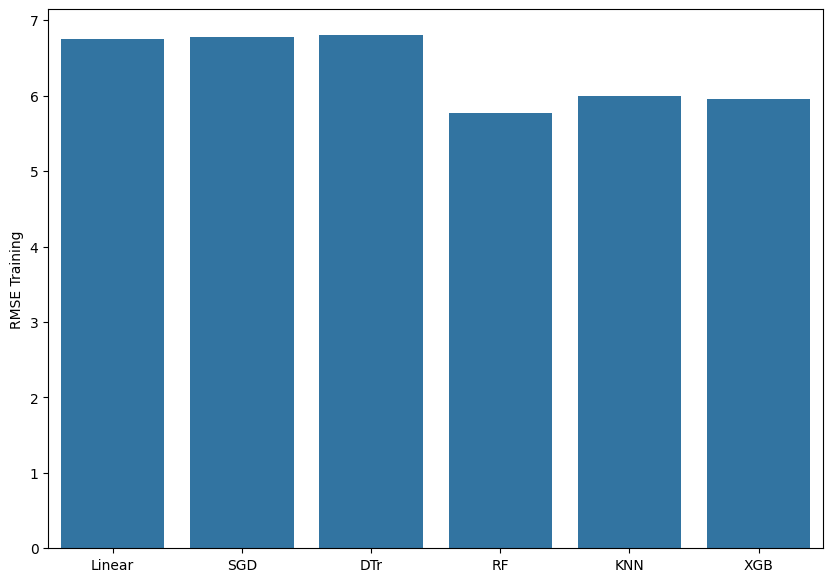

In [44]:
list_scores = [sc_linear,sc_sgd, sc_dtree, sc_rf, sc_knn, sc_xgb]
list_predictions = [pred_linreg_all, pred_sgd, pred_dtree, pred_rf, pred_knn, pred_xgb]
list_regressors = ['Linear','SGD','DTr','RF','KNN','XGB']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE Training')
plt.show()

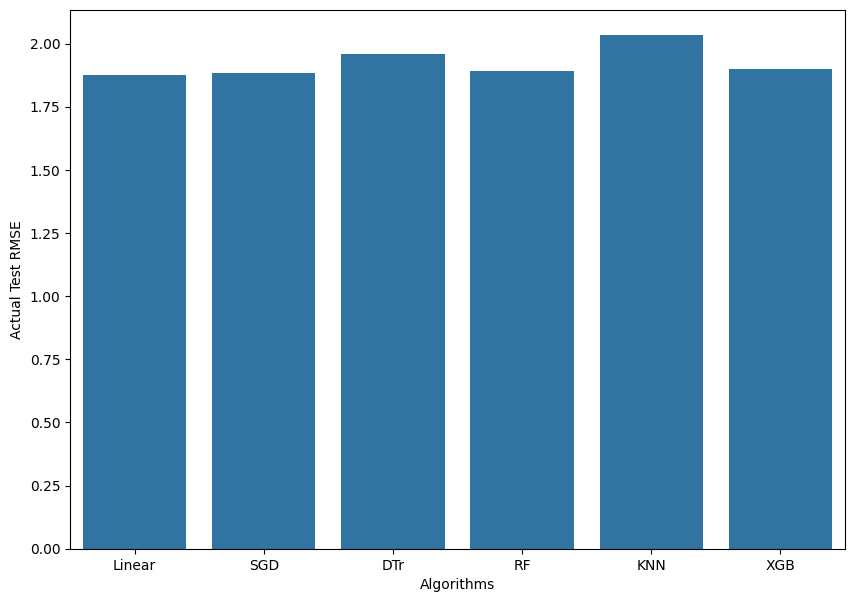

In [54]:
errors = []
for pred in list_predictions:
    errors.append(np.log(np.sqrt(mean_squared_error(y_test,pred))))

regressors = ['Linear','SGD','DTr','RF','KNN','XGB']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x = regressors, y = errors, ax=ax)
plt.ylabel('Actual Test RMSE')
plt.xlabel('Algorithms')
plt.show()

In [69]:
predictions = {'Linear': pred_linreg_all.ravel(),
               'SGD': pred_sgd, 'DTr': pred_dtree, 'RF': pred_rf,
               'KNN': pred_knn.ravel(), 'XGB': pred_xgb}
df_predictions = pd.DataFrame(data=predictions)

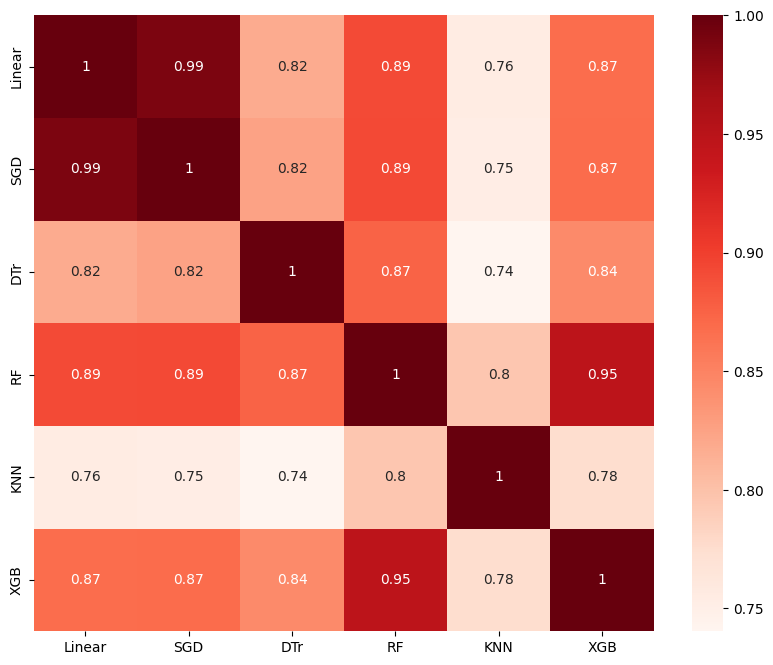

In [70]:
plt.figure(figsize=(10,8))
cor_pred = df_predictions.corr()
sns.heatmap(cor_pred, annot=True, cmap=plt.cm.Reds)
plt.show()

# Meta Model Approach

In [ ]:

# Initialize base models
rf = RandomForestRegressor(n_estimators=50, random_state=42)
knn = KNeighborsRegressor(n_neighbors=5)
lr = LinearRegression()

# Fit base models on training data
rf.fit(x_train, y_train['rh100'])
knn.fit(x_train, y_train)
lr.fit(x_train, y_train)

# Generate base model predictions on training and validation data
rf_pred_train = rf.predict(x_train)
knn_pred_train = knn.predict(x_train)
lr_pred_train = lr.predict(x_train)

rf_pred_val = rf.predict(x_test)
knn_pred_val = knn.predict(x_test)
lr_pred_val = lr.predict(x_test)

test

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Combine base model predictions into meta features
meta_features_train = np.column_stack((rf_pred_train, knn_pred_train, lr_pred_train))
meta_features_val = np.column_stack((rf_pred_val, knn_pred_val, lr_pred_val))

# Initialize meta model
ridge = Ridge(alpha=0.5)

In [ ]:
# Fit meta model on meta features and training target variable
ridge.fit(meta_features_train, y_train)

# Generate meta model predictions on validation set
meta_pred_val = ridge.predict(meta_features_val)

from sklearn.metrics import mean_squared_error

# Calculate MSE on validation set
mse = mean_squared_error(y_test, meta_pred_val)
print("MSE on validation set: {:.4f}".format(mse))


print("MAE train on test",mean_absolute_error(y_test, meta_pred_val))

print("MSE train on test",mean_squared_error(y_test, meta_pred_val))

r2 = r2_score(y_test, meta_pred_val)
print("R2 train on test", r2)

print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test, meta_pred_val))))

MSE on validation set: 54.6390
MAE train on test 5.471050173272121
MSE train on test 54.638992794398284
R2 train on test 0.34419505369899395
RMSE train on test 2.000373890803989


In [ ]:
meta_pred_val

array([[27.08725345],
       [ 3.77953355],
       [13.32184751],
       ...,
       [18.21901925],
       [14.63953038],
       [15.2205171 ]])

In [ ]:
rf_test_plot_df = pd.DataFrame({'y_test':y_test['rh100'], 'pred':meta_pred_val})
# rf_test_plot_df.plot('y_test', 'pred', kind='scatter')

sns.regplot(data=rf_test_plot_df,x = 'y_test', y = 'meta_pred_val',  ci=99, marker="x", color=".3", line_kws=dict(color="r"))

ValueError: Per-column arrays must each be 1-dimensional